In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate as interp
from scipy.signal import spectrogram
import utm

In [2]:
# only first third of this particular dataset was useful, normally none of this should be sliced!!!!!!!!!

mag_path = 'data/mag_engi_4-18.csv'
gps_path = 'data/gps_engi_4-18.csv'

# magnetic coil data acquisition sampling rate
sample_rate = int(1e4)
mag_data = pd.read_csv(mag_path)
mag_times = mag_data['Times (s)'].to_numpy()[:sample_rate*100]
mag_ch1_voltages = mag_data[' Ch 1 Voltage (V)'].to_numpy()[:sample_rate*100]
mag_ch2_voltages = mag_data[' Ch 2 Voltage (V)'].to_numpy()[:sample_rate*100]
# AC voltages computed by subtracting means from raw voltages
mag_ch1_ac_voltages = mag_ch1_voltages-np.mean(mag_ch1_voltages)
mag_ch2_ac_voltages = mag_ch2_voltages-np.mean(mag_ch2_voltages)
# RMS voltages computed by subtracting means from the RMS of the AC voltages
num_rms_bins = int(len(mag_ch1_ac_voltages)/sample_rate)
mag_ch1_rms_voltages = [np.sqrt(np.mean(np.square(mag_ch1_ac_voltages[i*sample_rate:(i+1)*sample_rate]))).tolist() for i in range(num_rms_bins)]
mag_ch2_rms_voltages = [np.sqrt(np.mean(np.square(mag_ch2_ac_voltages[i*sample_rate:(i+1)*sample_rate]))).tolist() for i in range(num_rms_bins)]
mag_ch1_rms_voltages = mag_ch1_rms_voltages - np.mean(mag_ch1_rms_voltages)
mag_ch2_rms_voltages = mag_ch2_rms_voltages - np.mean(mag_ch2_rms_voltages)

gps_data = pd.read_csv(gps_path)
gps_times = gps_data['Times (s)'].to_numpy()[:100]
gps_lat = gps_data['Latitude'].to_numpy()[:100]
gps_lon = gps_data['Longitude'].to_numpy()[:100]

# Conversion from GPS global latitude and longitude to UTM latitude and longitude (in [m])
utm_lat, utm_lon, zone_num, zone_letter = utm.from_latlon(gps_lat, gps_lon)

Interpolation of RMS Voltages to GPS Coordinates

In [3]:
# Interpolate mag data to gps coords
mag_ch1_voltages_interp = interp.interp1d(mag_times[::sample_rate], mag_ch1_rms_voltages, kind='cubic', fill_value='extrapolate')
mag_ch2_voltages_interp = interp.interp1d(mag_times[::sample_rate], mag_ch2_rms_voltages, kind='cubic', fill_value='extrapolate')
mag_ch1_voltages_at_gps_coords = mag_ch1_voltages_interp(gps_times)
mag_ch2_voltages_at_gps_coords = mag_ch2_voltages_interp(gps_times)

Mapping of Secondary Coil Voltages and Complex Field Phase

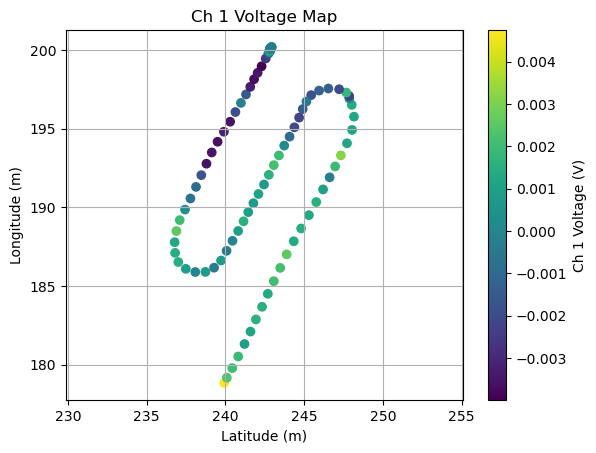

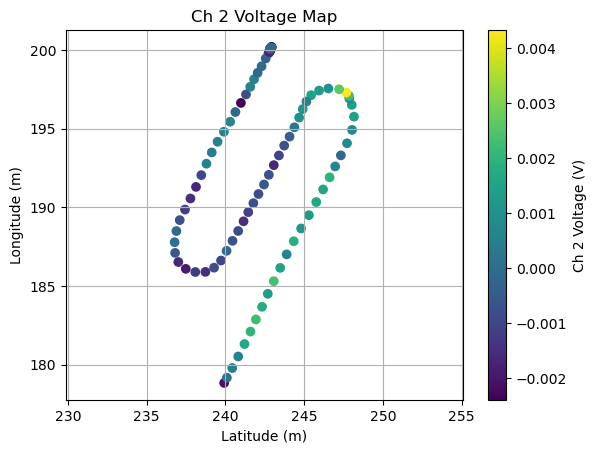

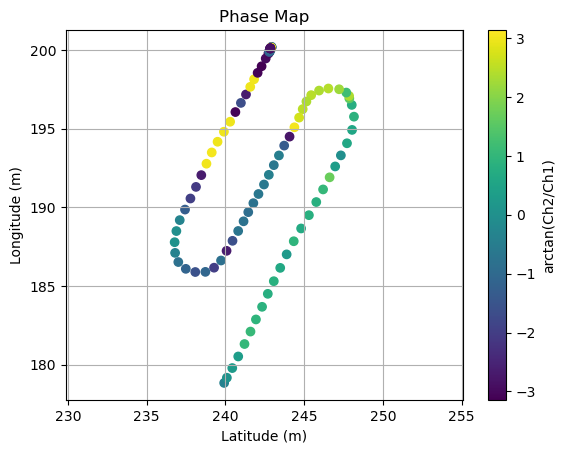

In [8]:
mag_map = plt.scatter(x=utm_lat%1000, y=utm_lon%1000, c=mag_ch1_voltages_at_gps_coords, cmap='viridis')
plt.colorbar(mag_map, label='Ch 1 Voltage (V)')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Ch 1 Voltage Map')
plt.axis('equal')
plt.grid(True)
plt.show()

mag_map = plt.scatter(x=utm_lat%1000, y=utm_lon%1000, c=mag_ch2_voltages_at_gps_coords, cmap='viridis')
plt.colorbar(mag_map, label='Ch 2 Voltage (V)')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Ch 2 Voltage Map')
plt.axis('equal')
plt.grid(True)
plt.show()

mag_field_phase = np.arctan2(mag_ch2_voltages_at_gps_coords, mag_ch1_voltages_at_gps_coords)
mag_map = plt.scatter(x=utm_lat%1000, y=utm_lon%1000, c=mag_field_phase, cmap='viridis')
plt.colorbar(mag_map, label='arctan(Ch2/Ch1)')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Phase Map')
plt.axis('equal')
plt.grid(True)
plt.show()

Mapping of Secondary Coil Fundamental and Third Harmonic Frequency Components and Complex Field Phase (at the fundamental)

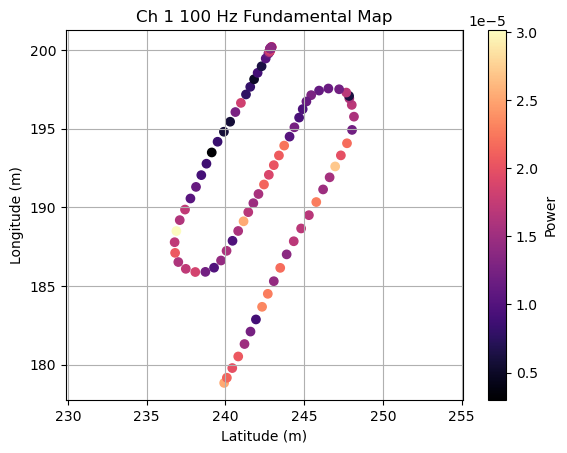

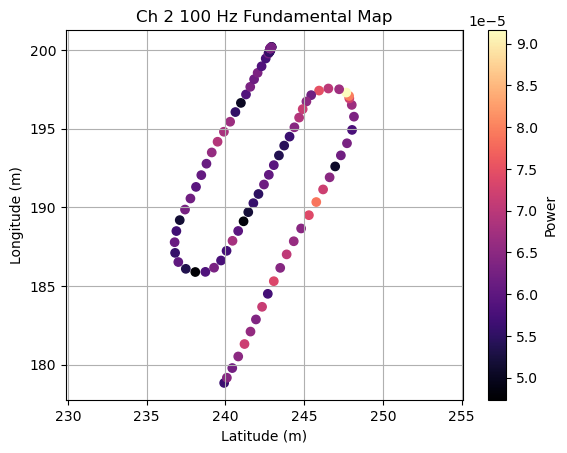

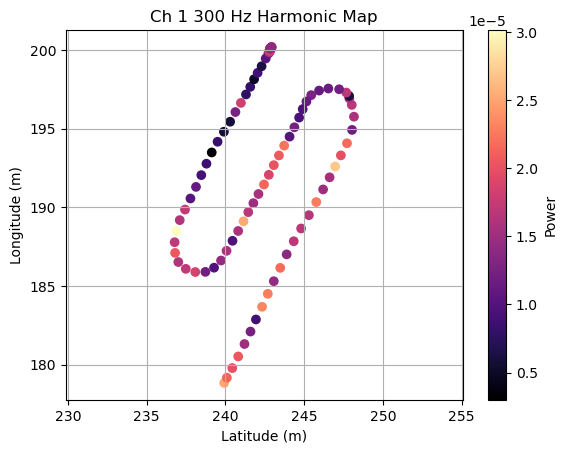

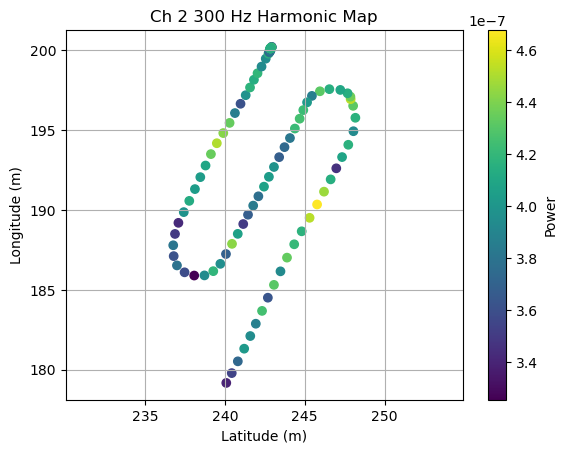

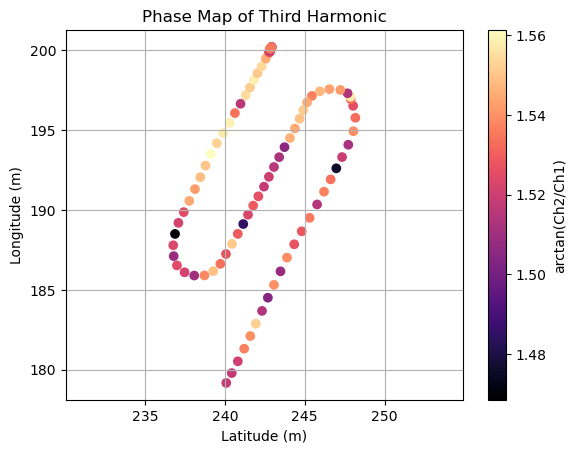

In [64]:
frequencies, times, Sxx = spectrogram(mag_ch1_ac_voltages, fs=sample_rate, nperseg=1024)
mag_ch1_fundamental_interp = interp.interp1d(times, Sxx[10], kind='cubic', fill_value='extrapolate')
mag_ch1_fundamental_at_gps_coords = mag_ch1_fundamental_interp(gps_times)
mag_map = plt.scatter(x=utm_lat%1000, y=utm_lon%1000, c=mag_ch1_fundamental_at_gps_coords, cmap='magma')
plt.colorbar(mag_map, label='Power')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Ch 1 100 Hz Fundamental Map')
plt.axis('equal')
plt.grid(True)
plt.show()

frequencies, times, Sxx = spectrogram(mag_ch2_ac_voltages, fs=sample_rate, nperseg=1024)
mag_ch2_fundamental_interp = interp.interp1d(times, Sxx[10], kind='cubic', fill_value='extrapolate')
mag_ch2_fundamental_at_gps_coords = mag_ch2_fundamental_interp(gps_times)
mag_map = plt.scatter(x=utm_lat%1000, y=utm_lon%1000, c=mag_ch2_fundamental_at_gps_coords, cmap='magma')
plt.colorbar(mag_map, label='Power')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Ch 2 100 Hz Fundamental Map')
plt.axis('equal')
plt.grid(True)
plt.show()

frequencies, times, Sxx = spectrogram(mag_ch1_ac_voltages, fs=sample_rate, nperseg=1024)
mag_ch1_3harmonic_interp = interp.interp1d(times, Sxx[30], kind='cubic', fill_value='extrapolate')
mag_ch1_3harmonic_at_gps_coords = mag_ch1_3harmonic_interp(gps_times)
mag_map = plt.scatter(x=utm_lat%1000, y=utm_lon%1000, c=mag_ch1_fundamental_at_gps_coords, cmap='magma')
plt.colorbar(mag_map, label='Power')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Ch 1 300 Hz Harmonic Map')
plt.axis('equal')
plt.grid(True)
plt.show()

frequencies, times, Sxx = spectrogram(mag_ch2_ac_voltages, fs=sample_rate, nperseg=1024)
mag_ch2_3harmonic_interp = interp.interp1d(times, Sxx[30], kind='cubic', fill_value='magma')
mag_ch2_3harmonic_at_gps_coords = mag_ch2_3harmonic_interp(gps_times[1:])
mag_map = plt.scatter(x=utm_lat[1:]%1000, y=utm_lon[1:]%1000, c=mag_ch2_3harmonic_at_gps_coords, cmap='viridis')
plt.colorbar(mag_map, label='Power')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Ch 2 300 Hz Harmonic Map')
plt.axis('equal')
plt.grid(True)
plt.show()

mag_field_phase = np.arctan2(mag_ch2_3harmonic_at_gps_coords, mag_ch1_3harmonic_at_gps_coords[1:])
mag_map = plt.scatter(x=utm_lat[1:]%1000, y=utm_lon[1:]%1000, c=mag_field_phase, cmap='magma')
plt.colorbar(mag_map, label='arctan(Ch2/Ch1)')
plt.xlabel('Latitude (m)')
plt.ylabel('Longitude (m)')
plt.title('Phase Map of Third Harmonic')
plt.axis('equal')
plt.grid(True)
plt.show()


In [9]:
logname = "arcgis_data.csv"
path = os.path.expanduser('data/'+logname)
logfile = open(path, "w")
logfile.write("Times (s),GPS Lat,GPS Lon,Ch 1 Voltage (V),Ch 2 Voltage (V),Phase\n")
for i in range(len(gps_times)):
        logfile.write(f"{gps_times[i]},{gps_lat[i]},{gps_lon[i]},\
                        {mag_ch1_voltages_at_gps_coords[i]:.7f},{mag_ch2_voltages_at_gps_coords[i]:.7f},{mag_field_phase[i]:.7f}\n")
logfile.close()